## Robot navigation 

**This file gives a simple robot navigation case study**

### Initialize the Robot Dynamics

In [1]:
# load dynamics
from Demos.demo_Models import simple_robot
import polytope as pc
import numpy as np

Robot = simple_robot()  # type: 

Robot.input_space = pc.box2poly(np.kron(np.ones((Robot.m, 1)), np.array([[-1, 1]])))  # continuous set of inputs
Robot.state_space = pc.box2poly(np.kron(np.ones((Robot.dim, 1)), np.array([[-10, 10]])))  # X space
 


Load robot model: Simple integrator model
[[0.31623 0.     ]
 [0.      0.31623]]


In [2]:
from best.models.pomdp import POMDP, POMDPNetwork
from best.models.pomdp_sparse_utils import get_T_uxXz, diagonal
from best.solvers.occupation_lp_new import *
from Reduce.Gridding import grid

d_opt = np.array([[0.69294], [0.721]]) # tuned gridding ratio from a previous paper
 

d = 1.1 * d_opt  # with distance measure 0.6=default
un = 3

Ms, srep  = grid(Robot, d, un=un)

print('# states')
print(len(Ms._state_space))
network = POMDPNetwork()

T00 = Ms.transition

network.add_pomdp(POMDP(T00, input_names=['a'], state_name='s'))

T0 = np.array([[1, 0],
               [0, 1]]);
T1 = np.array([[0, 1],
               [0, 1]]);
network.add_pomdp(POMDP([T0, T1], input_names=['l'], state_name='q'))
Ms._state_space[-1] = (np.nan,np.nan)
# (Ms._state_space[s][0] > 4)

network.add_connection(['s'], 'l', lambda s: set([1]) if (Ms._state_space[s][0] > 4) else set([0]) )
accept = np.zeros((T00.shape[1],2))
accept[:,1] = 1

val_list, pol_list = solve_reach(network, accept)
Robotmdp = diagonal(get_T_uxXz(network.pomdps['s']), 2, 3)
Robotdfa = diagonal(get_T_uxXz(network.pomdps['q']), 2, 3)
conn = network.connections[0][2].transpose()

t=time.time()
delta = 0.01
# reach_prob, val2 = solve_delta(self.mdp1, self.dfa1, conn, delta, s0=0, q0=0, q_target=1)
strat = np.array([[0] * (Robotmdp.shape[2]), [1] * (Robotmdp.shape[2])]).transpose()
strat = strat[conn]


model, reach_prob = solve_ltl(Robotmdp.todense(), Robotdfa.todense(), strat, delta, s0=0, q0=0, q_target=1)
# np.testing.assert_almost_equal(reach_prob['primal objective'], val_list[0][0, 0], decimal=5)
print(reach_prob)
print([reach_prob['primal objective']])
print([time.time()-t])


------- start gridding -------
# states
757
finished after 0.17s and 22 iterations
Academic license - for non-commercial use only
create empty model 0.026530027389526367
added variables 13.305361032485962
Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored
added constraints 30.70559310913086
Optimize a model with 757 rows, 6813 columns and 169257 nonzeros
Coefficient statistics:
  Matrix range     [2e-13, 1e+00]
  Objective range  [8e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 244 rows and 2196 columns
Presolve time: 0.37s
Presolved: 513 rows, 4617 columns, 156765 nonzeros

Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 2.787e+04
 Factor NZ  : 6.216e+04 (roughly 3 MBytes of memory)
 Factor Ops : 8.472e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Pr

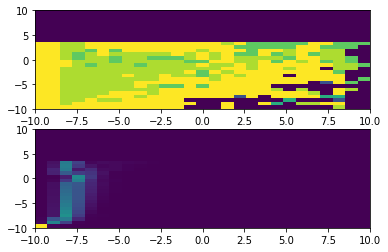

In [3]:
import scipy.sparse
import matplotlib.pyplot as plt

m = scipy.sparse.coo_matrix((reach_prob['x'],(np.array(reach_prob['indices'])[::,1],np.array(reach_prob['indices'])[::,2])))
Pol = m.argmax(1)
Z = m.sum(1)
Z = Z[:-1:].reshape(len(srep[0]),len(srep[1]))
Pol = Pol[:-1:].reshape(len(srep[0]),len(srep[1]))


fig, (ax0, ax1) = plt.subplots(2, 1)

ax0.pcolorfast((-10,10),(-10,10),np.array(Pol))
ax1.pcolorfast((-10,10),(-10,10),np.array(Z))
plt.show()